# Example of usе

In [81]:
%%bash
docker run -p 5000:5000 -dt --name my_server --rm \
    ghcr.io/mlflow/mlflow \
    bash -c "mlflow server --host 0.0.0.0 --port 5000"

2a736665564bc82fe3d1981288cda7fb05953fcf23fe3a87235b17cfce39c6f9


In [9]:
!docker stop my_server

my_server


In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    RocCurveDisplay,
    confusion_matrix,
    roc_curve
)
from sklearn.model_selection import KFold
import mlflow
import mlflow.sklearn
print("Numpy: {}".format(np.__version__))
print("Pandas: {}".format(pd.__version__))
print("matplotlib: {}".format(matplotlib.__version__))
print("seaborn: {}".format(sns.__version__))
print("Scikit-Learn: {}".format(sklearn.__version__))
print("MLFlow: {}".format(mlflow.__version__))

mlflow.set_tracking_uri(uri="http://localhost:5000")

Numpy: 1.24.2
Pandas: 2.2.1
matplotlib: 3.7.1
seaborn: 0.12.2
Scikit-Learn: 1.4.1.post1
MLFlow: 2.11.3


In [2]:
df = pd.read_csv("creditcard.csv")
df.drop("Time", axis=1, inplace=True)
display(df.head())

x = df.drop("Class",axis=1)
y = df["Class"]

x_train, x_test, y_train, y_test =\
    train_test_split(
        x, y, test_size=0.2, 
        stratify=y, random_state=2020
    )
x_train, x_validate, y_train, y_validate = \
    train_test_split(
        x_test, y_test, test_size=0.25, 
        stratify=y_test, random_state=2020
    )

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
scaler = StandardScaler()
scaler.fit(x)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_validate = scaler.transform(x_validate)

In [4]:
def train(sk_model, x_train, y_train):
    sk_model = sk_model.fit(x_train, y_train)
    train_acc = sk_model.score(x_train, y_train)
    mlflow.log_metric("train_acc", train_acc)
    print(f"Train Accuracy: {train_acc:.3%}")

In [5]:
def evaluate(sk_model, x_test, y_test):
    
    eval_acc = sk_model.score(x_test, y_test)
    preds = sk_model.predict_proba(x_test)[:,1]
    auc_score = roc_auc_score(y_test, preds)
    
    mlflow.log_metric("eval_acc", eval_acc)
    mlflow.log_metric("auc_score", auc_score)
    
    print(f"Auc Score: {auc_score:.3%}")
    print(f"Eval Accuracy: {eval_acc:.3%}")

    fpr, tpr, _ = roc_curve(
        y_test,
        sk_model.predict_proba(x_test)[:,1],
    )
    
    roc_plot = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    plt.savefig("sklearn_roc_plot.png")
    plt.show()
    plt.clf()
    conf_matrix = confusion_matrix(y_test, preds>0.5)
    ax = sns.heatmap(conf_matrix, annot=True,fmt='g')
    ax.invert_xaxis()
    ax.invert_yaxis()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title("Confusion Matrix")
    plt.savefig("sklearn_conf_matrix.png")
    mlflow.log_artifact("sklearn_roc_plot.png")
    mlflow.log_artifact("sklearn_conf_matrix.png")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Train Accuracy: 99.960%
Auc Score: 98.703%
Eval Accuracy: 99.946%


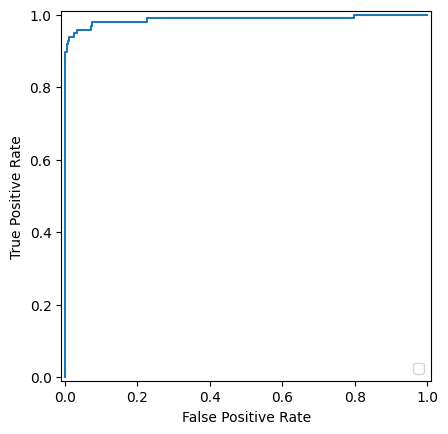

Model run:  f4cfb9af73dd4a4191d9bd96df5f4954


/home/fedor/.local/lib/python3.10/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/fedor/.local/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


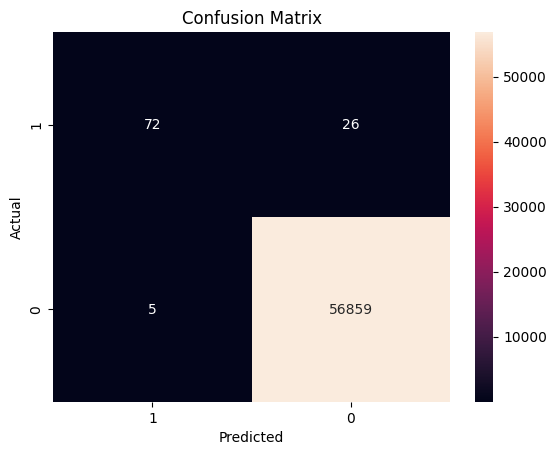

In [8]:
sk_model = LogisticRegression(random_state=None,
max_iter=400, solver='newton-cg')
mlflow.set_experiment("scikit_learn_experiment")
with mlflow.start_run():
    mlflow.set_tag("mlflow.runName", "run_name")
    train(sk_model, x_train, y_train)
    evaluate(sk_model, x_test, y_test)
    mlflow.sklearn.log_model(sk_model,
    "log_reg_model")
    print(
        "Model run: ",
        mlflow.active_run().info.run_uuid
    )
    mlflow.end_run()